In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

### Create the Dense Block

In [2]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
                        nn.BatchNorm2d(input_channels), nn.ReLU(),
                        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
                        )

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []   # create an empty list for storing layers
        for i in range(num_convs):
            layer.append(conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
        
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)  # concatenate the input and output of each block on channel dim
        return X

In [4]:
# create a DenseBlock with 2 conv blocks
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8) 
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### Build the Transition Layer

In [5]:
# Transition Block uses 1x1 conv layer to reduce the channels and uses avgpool to halves the H&W 
def transition_block(input_channels, num_channels):
    return nn.Sequential(
                        nn.BatchNorm2d(input_channels), nn.ReLU(),
                        nn.Conv2d(input_channels, num_channels, kernel_size=1),
                        nn.AvgPool2d(kernel_size=2, stride=2)
                        )

In [6]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### Build the DenseNet Model

In [7]:
stage1 = nn.Sequential(
                    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm2d(64), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                        )

In [8]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []

In [9]:
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    # since we use 'enumerate', so i = 0 to 3; num_convs = 4
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous Dense block
    num_channels += num_convs * growth_rate  
    # Transition layer is added between the Dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2)) #   // means get the integer 
        num_channels = num_channels // 2

In [10]:
net = nn.Sequential(
                    stage1, *blks, nn.BatchNorm2d(num_channels), nn.ReLU(),
                    nn.AdaptiveMaxPool2d((1, 1)), nn.Flatten(),
                    nn.Linear(num_channels, 10)
                   )

loss 0.134, train acc 0.950, test acc 0.913
2022.8 examples/sec on cuda:0


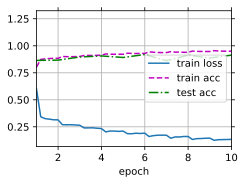

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())